In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from pkg import u,m

clen_values, photon_energy_values = [1.5, 2.5, 3.5], [6000, 7000, 8000]
param_matrix = u.parameter_matrix(clen_values, photon_energy_values)
print(param_matrix, '\n')

dataset_dict = {
    '01': [clen_values[0], photon_energy_values[0]],
    '02': [clen_values[0], photon_energy_values[1]],
    '03': [clen_values[0], photon_energy_values[2]],
    '04': [clen_values[1], photon_energy_values[0]],
    '05': [clen_values[1], photon_energy_values[1]],
    '06': [clen_values[1], photon_energy_values[2]],
    '07': [clen_values[2], photon_energy_values[0]],
    '08': [clen_values[2], photon_energy_values[1]],
    '09': [clen_values[2], photon_energy_values[2]],
}


# parameters
dataset = '01'
print(dataset_dict[dataset])
clen, photon_energy = dataset_dict[dataset]
threshold = 1
# clen = 1.5 # meters 
# photon_energy = 6000 # eV/ 6 keV

# instances
pm = u.PathManager()
peak_paths, water_peak_paths, labels, water_background_path = pm.select_dataset(dataset=dataset)
p = u.Processor(paths=pm, dataset=dataset)
dm = u.DatasetManager(paths=pm, dataset=dataset, transform=None)


true parameter matrix...

[[(1.5, 6000.) (1.5, 7000.) (1.5, 8000.)]
 [(2.5, 6000.) (2.5, 7000.) (2.5, 8000.)]
 [(3.5, 6000.) (3.5, 7000.) (3.5, 8000.)]] 

[1.5, 6000]
Found water background image: water01.h5
Number of peak images: 39
Number of water images: 39
Number of label images: 39
Check: Path to water background image: /home/eseverett/Desktop/CXFEL/cxls_hitfinder/images/water/01/water01.h5



In [2]:
# p.process_directory(dataset=dataset, clen=clen, photon_energy=photon_energy)

In [3]:
# generate peak/overlay/label and upate attributes
# overlaying the correct water01.h5 path to the peak images
# p.process_directory(dataset=dataset, clen=clen, photon_energy=photon_energy)

# peak, label, overlay, background are valid types
u.check_attributes(paths=pm, dataset=dataset, type='label') 

train_loader, test_loader = u.prepare(data_manager=dm, batch_size=10)


true parameter matrix...

All files in dataset 01 of type 'label' have matching attributes.

Data prepared.
Train size: 31
Test size: 8
Batch size: 10
Number of batches in train_loader: 4 



In [4]:
model1 = m.BasicCNN1()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = {
    'num_epochs': 3,
    'num_classes': 2,
    'batch_size': train_loader.batch_size,
    'test_size': len(train_loader.dataset),
    'test_size': len(test_loader.dataset),
    'criterion': criterion,
    'optimizer': optimizer,
    'device': device,
    'model': model1,
}

# arguments: self, model, loader: list, criterion, optimizer, device, cfg: dict
t = u.TrainTestModels(model=model1, loader=[train_loader, test_loader], criterion=criterion, optimizer=optimizer, device=device, cfg=cfg)

In [5]:
t.epoch_loop()

Model testing and validating: BasicCNN1
-- epoch 0


Train loss: 0.3003009557723999
Train accuracy: 2.3880462322267704e-05
Test loss: 0.07354052066802978
Test accuracy: 6.81805977365002e-05
-- epoch 1
Train loss: 0.29048028588294983
Train accuracy: 0.00012480118311941624
Test loss: 0.0710757315158844
Test accuracy: 0.000541422632522881
-- epoch 2
Train loss: 0.2805707335472107
Train accuracy: 0.03277360275387764
Test loss: 0.0685831367969513
Test accuracy: 0.9962195158004761


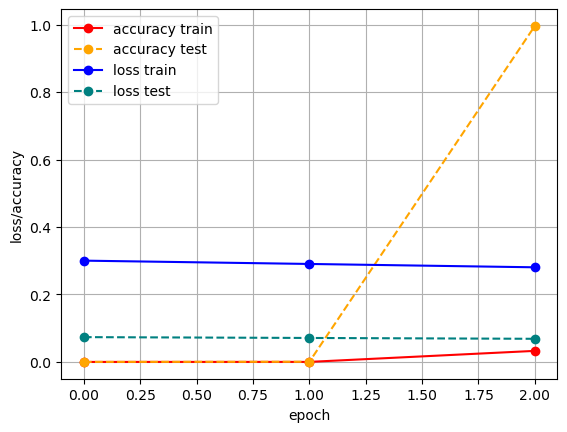

In [6]:
t.plot_loss_accuracy()

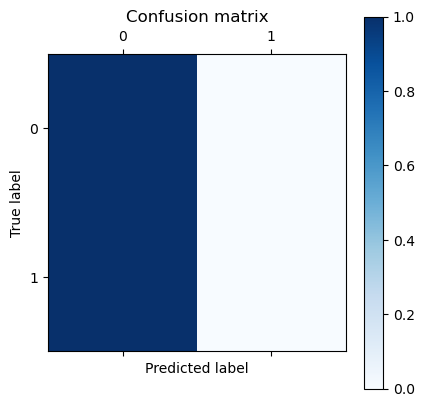

In [7]:
t.plot_confusion_matrix()

In [8]:
t.get_confusion_matrix()

array([[0.99622037, 0.00377963],
       [1.        , 0.        ]])